In [2]:
import json
import pandas as pd
import numpy as np
from scipy.optimize import linear_sum_assignment
import Levenshtein
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load data (same as in your n-grams approach)
with open('translate/atomic_claims_FCGPT_claude_translated.json', 'r') as file:
    loki_translated = json.load(file)

with open('translate/translated.json', 'r') as file:
    dataset_translated = json.load(file)


In [4]:
# Extract claims (same extraction logic)
gt_claims = []
for entry in dataset_translated:
    for item in entry.get('claims', []):
        if isinstance(item, list):
            for claim in item:
                gt_claims.append(claim)
        elif isinstance(item, dict):
            gt_claims.append(item.get('claim', ''))
        elif isinstance(item, str):
            gt_claims.append(item)

loki_claims = []
for entry in loki_translated:
    for item in entry.get('claims', []):
        if isinstance(item, list):
            for claim in item:
                loki_claims.append(claim)
        elif isinstance(item, dict):
            loki_claims.append(item.get('claim', ''))
        elif isinstance(item, str):
            loki_claims.append(item)

print(f"Number of GT claims: {len(gt_claims)}")
print(f"Number of generated claims: {len(loki_claims)}")

Number of GT claims: 678
Number of generated claims: 837


In [5]:
# Function to compute normalized similarity from edit distance
def compute_edit_similarity(reference, candidate):
    # Get raw Levenshtein distance
    edit_distance = Levenshtein.distance(reference, candidate)

    # Normalize by the length of the longer string
    max_len = max(len(reference), len(candidate))
    if max_len == 0:  # Handle empty strings
        return 1.0

    # Convert to similarity (1 - normalized distance)
    similarity = 1 - (edit_distance / max_len)
    return similarity

# Create similarity matrix using edit distance
num_gt = len(gt_claims)
num_gen = len(loki_claims)
similarity_matrix = np.zeros((num_gt, num_gen))

for i in range(num_gt):
    for j in range(num_gen):
        similarity_matrix[i, j] = compute_edit_similarity(gt_claims[i], loki_claims[j])


In [6]:
# Hungarian algorithm for optimal matching
cost_matrix = -similarity_matrix  # Convert similarity to cost
row_ind, col_ind = linear_sum_assignment(cost_matrix)

# Create dataframe of matched pairs
pairs = []
for r, c in zip(row_ind, col_ind):
    pairs.append({
        'GT_Claim': gt_claims[r],
        'Generated_Claim': loki_claims[c],
        'Edit_Similarity': similarity_matrix[r, c]
    })

df_pairs = pd.DataFrame(pairs)

In [7]:
# Calculate metrics
threshold = 0.7  # Threshold for good match
avg_matched_score = np.mean(similarity_matrix[row_ind, col_ind])
matched_scores = similarity_matrix[row_ind, col_ind]
num_good_matches = np.sum(matched_scores >= threshold)
claim_recall = num_good_matches / num_gt

good_generated = set(c for r, c in zip(row_ind, col_ind) if similarity_matrix[r, c] >= threshold)
claim_precision = len(good_generated) / num_gen

print(f"Overall Average Edit Similarity for matched pairs: {avg_matched_score:.3f}")
print(f"Edit Distance Metric: Claim Recall (fraction of GT claims with a match >= {threshold}): {claim_recall:.2%}")
print(f"Edit Distance Metric: Claim Precision (fraction of generated claims that are good matches): {claim_precision:.2%}")


Overall Average Edit Similarity for matched pairs: 0.596
Edit Distance Metric: Claim Recall (fraction of GT claims with a match >= 0.7): 35.25%
Edit Distance Metric: Claim Precision (fraction of generated claims that are good matches): 28.55%


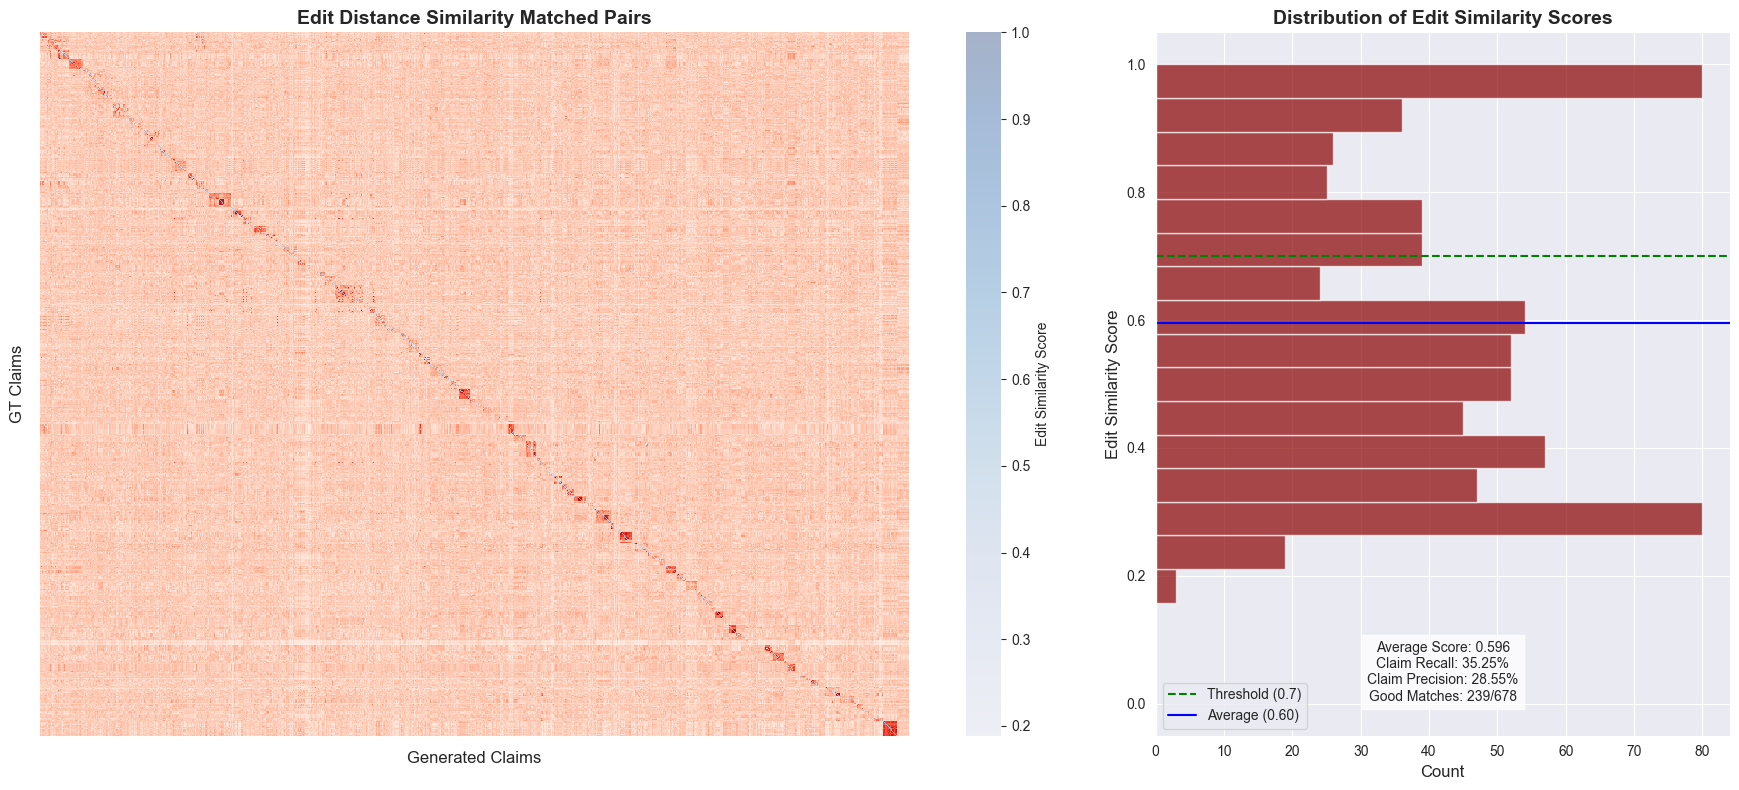

In [8]:
# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8), gridspec_kw={'width_ratios': [2, 1]})

# Create mask for highlighting matched pairs
mask = np.ones_like(similarity_matrix, dtype=bool)
for r, c in zip(row_ind, col_ind):
    mask[r, c] = False

# Plot heatmap with highlighted matches
sns.heatmap(
    similarity_matrix,
    cmap='Blues',
    mask=mask,
    cbar_kws={'label': 'Edit Similarity Score'},
    ax=ax1,
    square=True,
    alpha=0.3
)

sns.heatmap(
    similarity_matrix,
    cmap='Reds',
    mask=~mask,
    cbar=False,
    ax=ax1,
    square=True
)

ax1.set_title('Edit Distance Similarity Matched Pairs', fontsize=14, fontweight='bold')
ax1.set_xlabel('Generated Claims', fontsize=12)
ax1.set_ylabel('GT Claims', fontsize=12)

# Reduce tick density for large matrices
if similarity_matrix.shape[0] > 20 or similarity_matrix.shape[1] > 20:
    step = max(1, min(similarity_matrix.shape) // 10)
    ax1.set_xticks(np.arange(0, similarity_matrix.shape[1], step))
    ax1.set_yticks(np.arange(0, similarity_matrix.shape[0], step))

# Plot distribution of matched scores
bins = np.linspace(0, 1, 20)
ax2.hist(matched_scores, bins=bins, orientation='horizontal', color='darkred', alpha=0.7)
ax2.axhline(y=threshold, color='green', linestyle='--', label=f'Threshold ({threshold})')
ax2.axhline(y=avg_matched_score, color='blue', linestyle='-', label=f'Average ({avg_matched_score:.2f})')
ax2.set_title('Distribution of Edit Similarity Scores', fontsize=14, fontweight='bold')
ax2.set_xlabel('Count', fontsize=12)
ax2.set_ylabel('Edit Similarity Score', fontsize=12)
ax2.legend()

# Add metrics text
metrics_text = (
    f"Average Score: {avg_matched_score:.3f}\n"
    f"Claim Recall: {claim_recall:.2%}\n"
    f"Claim Precision: {claim_precision:.2%}\n"
    f"Good Matches: {num_good_matches}/{num_gt}"
)
ax2.text(0.5, 0.05, metrics_text, transform=ax2.transAxes,
         bbox=dict(facecolor='white', alpha=0.8), ha='center')

plt.tight_layout()
plt.show()

In [9]:
# Additional analysis: Compare with ROUGE metrics
# Create a scatter plot comparing both metrics for the same pairs
if 'rouge_scores' in locals():  # If you've run both approaches
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.scatter(rouge_scores, edit_scores, alpha=0.6)
    ax.set_xlabel('ROUGE F1 Score')
    ax.set_ylabel('Edit Similarity Score')
    ax.set_title('Comparison of ROUGE vs Edit Distance Metrics')
    ax.grid(True, linestyle='--', alpha=0.7)

    # Add diagonal line for reference
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.5)

    plt.tight_layout()
    plt.show()